## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pyreadr
import seaborn as sns
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Setup

In [2]:
# Set seed for reproducibility
seed = 42

# Create folders
os.makedirs(os.path.normpath(os.path.join("..", "sentiment_analysis_outputs")), exist_ok=True)
os.makedirs(os.path.normpath(os.path.join("..", "sentiment_analysis_eval_results")), exist_ok=True)

## Helpers

In [3]:
def make_embeddings(words_to_embeddings_mapping: dict[str, np.ndarray], reviews: list[list[str]]) -> np.ndarray:
    # Initialise final feature array
    num_reviews = len(reviews)
    vector_size = len(list(words_to_embeddings_mapping.values())[0])
    feature_vectors = np.zeros((num_reviews, vector_size))

    for i, review in enumerate(reviews):
        aggregated_feature_vector = np.zeros(vector_size)
        num_words_in_aggregation = 0

        for word in review:
            # We only aggregate for those words that exist in the vocab
            if word in words_to_embeddings_mapping:
                # Add the word embedding
                word_embedding = words_to_embeddings_mapping[word]
                aggregated_feature_vector += word_embedding
                num_words_in_aggregation += 1

        # To aggregate, we average the word embeddings
        # If no words added to aggregation, just take the aggregation to be a zero vector
        if num_words_in_aggregation != 0:
            aggregated_feature_vector /= num_words_in_aggregation

        feature_vectors[i] = aggregated_feature_vector

    return feature_vectors

In [4]:
def display_and_save_cm(cm: np.ndarray, filename: str) -> None:
    # Make heat map of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set_theme(font_scale=0.8)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # Save this heat map
    cm_file_path = os.path.join(os.path.normpath(os.path.join("..", "sentiment_analysis_eval_results")), f"{filename}_cm.png")
    plt.savefig(cm_file_path, bbox_inches="tight")

    # Display heat map
    print("Confusion Matrix:")
    plt.show()


def train_and_eval_classifier(model: ClassifierMixin, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, filename: str) -> ClassifierMixin:
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_preds = model.predict(X_test)

    # Calculate evaluation metrics
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, pos_label=1)
    recall = recall_score(y_test, y_preds, pos_label=1)
    f1 = f1_score(y_test, y_preds, pos_label=1)
    cm = confusion_matrix(y_test, y_preds)

    # Print evaluation metrics
    print(f"Accuracy: {round(acc * 100, 1)}%")
    print(f"Precision: {round(precision * 100, 1)}%")
    print(f"Recall: {round(recall * 100, 1)}%")
    print(f"F1 score: {round(f1 * 100, 1)}%")

    # Display and save confusion matrix
    display_and_save_cm(cm=cm, filename=filename)
    
    # Save fitted model
    with open(os.path.normpath(os.path.join("..", "sentiment_analysis_outputs", f"{filename}_model.pkl")), "wb") as f:
        pickle.dump(model, f)

    return model

## Load Models / Embeddings

In [5]:
# Word2Vec (no hyperparameter tuning)
with open(os.path.normpath(os.path.join("..", "embedding_outputs", "word2vec_model.pkl")), "rb") as f:
  word2vec_model = pickle.load(f)

word2vec_embeddings = word2vec_model.wv

# Get mapping of words to vector embeddings
word2vec_words_to_embeddings = {word: word2vec_embeddings[word] for word in word2vec_embeddings.key_to_index}


In [6]:
# SPPMI-SVD (with hyperparameter tuning)
with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings_ht.pkl")), "rb") as f:
  sppmi_svd_embeddings = pickle.load(f)

with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings_mapping_ht.pkl")), "rb") as f:
  sppmi_svd_embeddings_mapping = pickle.load(f)

# Get mapping of words to vector embeddings
sppmi_svd_words_to_embeddings = {word: sppmi_svd_embeddings[id] for word, id in sppmi_svd_embeddings_mapping.items()}

In [7]:
# GloVe (with hyperparameter tuning)
glove_embeddings_df = pyreadr.read_r(os.path.normpath(os.path.join("..", "embedding_outputs", "glove_embeddings_ht.rds")))[None]

# Get mapping of words to vector embeddings
glove_words_to_embeddings = {word: np.array(glove_embeddings_df.loc[word]) for word in glove_embeddings_df.index.tolist()}

## Load Data

In [8]:
with open(os.path.normpath(os.path.join("..", "data", "reviews_train.pkl")), "rb") as f:
  reviews_train = pickle.load(f)

with open(os.path.normpath(os.path.join("..", "data", "reviews_test.pkl")), "rb") as f:
  reviews_test = pickle.load(f)

with open(os.path.normpath(os.path.join("..", "data", "labels_train.pkl")), "rb") as f:
  labels_train = pickle.load(f)

with open(os.path.normpath(os.path.join("..", "data", "labels_test.pkl")), "rb") as f:
  labels_test = pickle.load(f)

## Skip-Gram (Word2Vec)

### Get Embeddings

In [9]:
# Get features
word2vec_embeddings_train = make_embeddings(words_to_embeddings_mapping=word2vec_words_to_embeddings, reviews=reviews_train)
word2vec_embeddings_test = make_embeddings(words_to_embeddings_mapping=word2vec_words_to_embeddings, reviews=reviews_test)

### Random Forest

Accuracy: 73.0%
Precision: 76.6%
Recall: 66.7%
F1 score: 71.3%
Confusion Matrix:


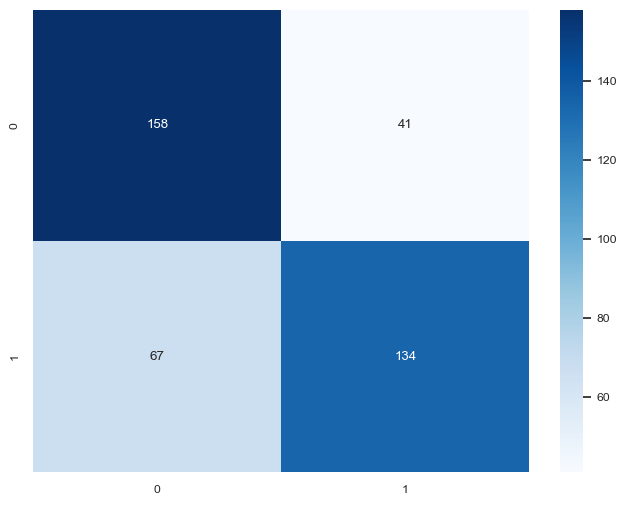

In [10]:
# Initialise model
word2vec_rf = RandomForestClassifier(random_state=seed)

# Train and evaluate
word2vec_rf_fitted = train_and_eval_classifier(model=word2vec_rf, X_train=word2vec_embeddings_train, y_train=labels_train, X_test=word2vec_embeddings_test, y_test=labels_test, filename="word2vec_rf")

### Support Vector Machine

Accuracy: 77.5%
Precision: 83.2%
Recall: 69.2%
F1 score: 75.5%
Confusion Matrix:


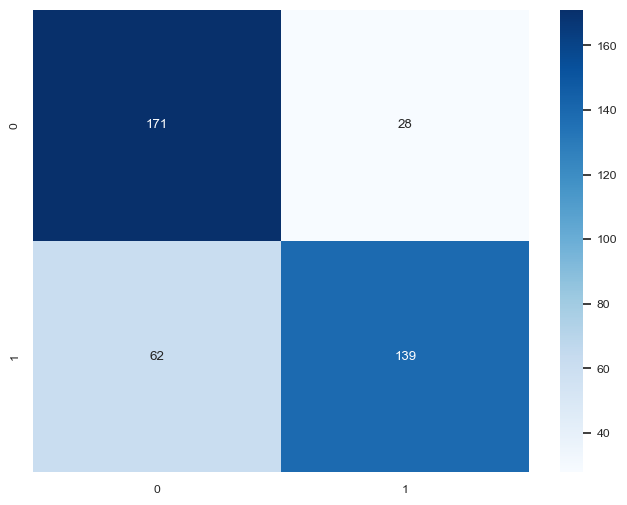

In [11]:
# Initialise model
word2vec_svm = SVC(random_state=seed)

# Train and evaluate
word2vec_svm_fitted = train_and_eval_classifier(model=word2vec_svm, X_train=word2vec_embeddings_train, y_train=labels_train, X_test=word2vec_embeddings_test, y_test=labels_test, filename="word2vec_svm")

### XGBoost

Accuracy: 74.8%
Precision: 78.1%
Recall: 69.2%
F1 score: 73.4%
Confusion Matrix:


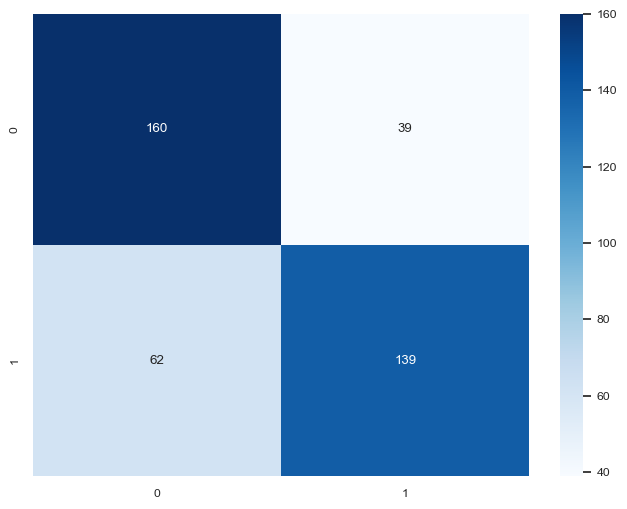

In [12]:
# Initialise model
word2vec_xgb = XGBClassifier(random_state=seed)

# Train and evaluate
word2vec_xgb_fitted = train_and_eval_classifier(model=word2vec_xgb, X_train=word2vec_embeddings_train, y_train=labels_train, X_test=word2vec_embeddings_test, y_test=labels_test, filename="word2vec_xgb")

## SPPMI-SVD

### Get Embeddings

In [13]:
# Get features
sppmi_svd_embeddings_train = make_embeddings(words_to_embeddings_mapping=sppmi_svd_words_to_embeddings, reviews=reviews_train)
sppmi_svd_embeddings_test = make_embeddings(words_to_embeddings_mapping=sppmi_svd_words_to_embeddings, reviews=reviews_test)

### Random Forest

Accuracy: 72.0%
Precision: 75.7%
Recall: 65.2%
F1 score: 70.1%
Confusion Matrix:


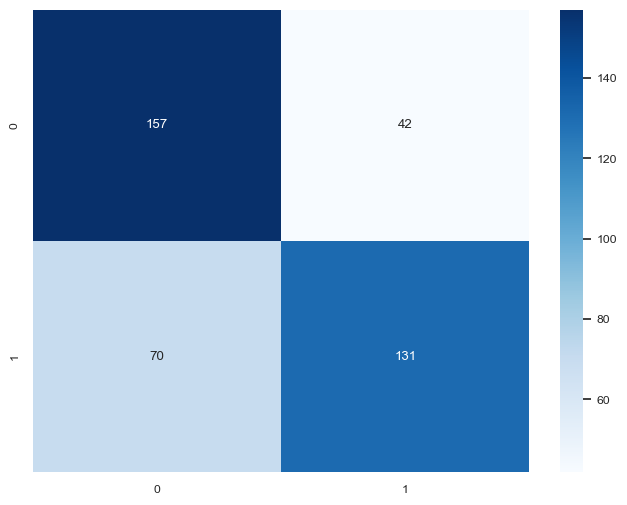

In [14]:
# Initialise model
sppmi_svd_rf = RandomForestClassifier(random_state=seed)

# Train and evaluate
sppmi_svd_rf_fitted = train_and_eval_classifier(model=sppmi_svd_rf, X_train=sppmi_svd_embeddings_train, y_train=labels_train, X_test=sppmi_svd_embeddings_test, y_test=labels_test, filename="sppmi_svd_rf")

### Support Vector Machine

Accuracy: 76.0%
Precision: 78.7%
Recall: 71.6%
F1 score: 75.0%
Confusion Matrix:


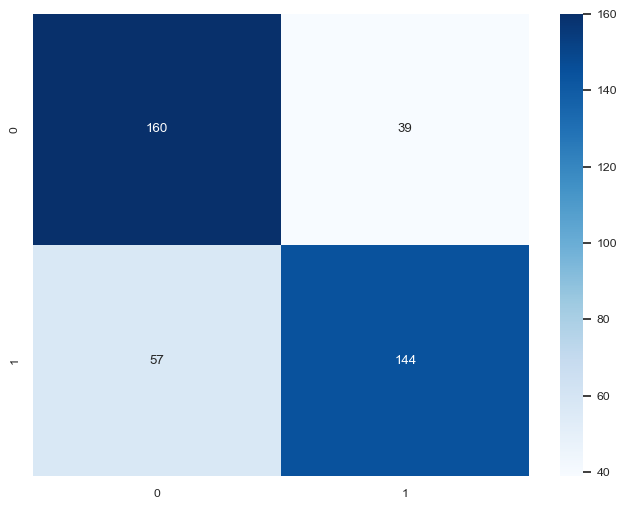

In [15]:
# Initialise model
sppmi_svd_svm = SVC(random_state=seed)

# Train and evaluate
sppmi_svd_svm_fitted = train_and_eval_classifier(model=sppmi_svd_svm, X_train=sppmi_svd_embeddings_train, y_train=labels_train, X_test=sppmi_svd_embeddings_test, y_test=labels_test, filename="sppmi_svd_svm")

### XGBoost

Accuracy: 74.8%
Precision: 75.8%
Recall: 73.1%
F1 score: 74.4%
Confusion Matrix:


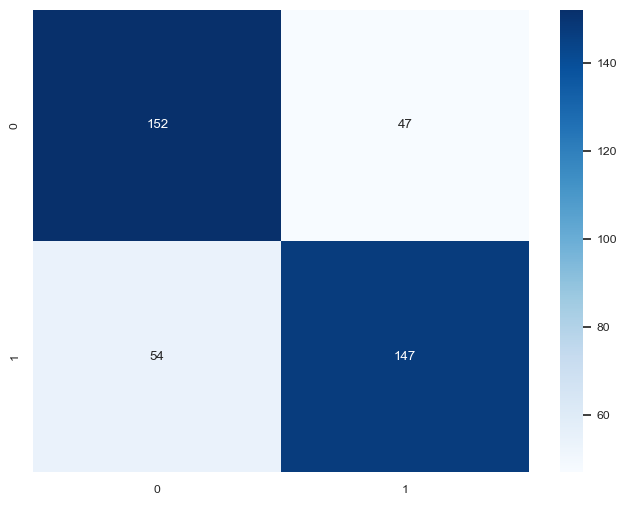

In [16]:
# Initialise model
sppmi_svd_xgb = XGBClassifier(random_state=seed)

# Train and evaluate
sppmi_svd_xgb_fitted = train_and_eval_classifier(model=sppmi_svd_xgb, X_train=sppmi_svd_embeddings_train, y_train=labels_train, X_test=sppmi_svd_embeddings_test, y_test=labels_test, filename="sppmi_svd_xgb")

## GloVe

### Get Embeddings

In [17]:
# Get features
glove_embeddings_train = make_embeddings(words_to_embeddings_mapping=glove_words_to_embeddings, reviews=reviews_train)
glove_embeddings_test = make_embeddings(words_to_embeddings_mapping=glove_words_to_embeddings, reviews=reviews_test)

### Random Forest

Accuracy: 66.0%
Precision: 67.6%
Recall: 62.2%
F1 score: 64.8%
Confusion Matrix:


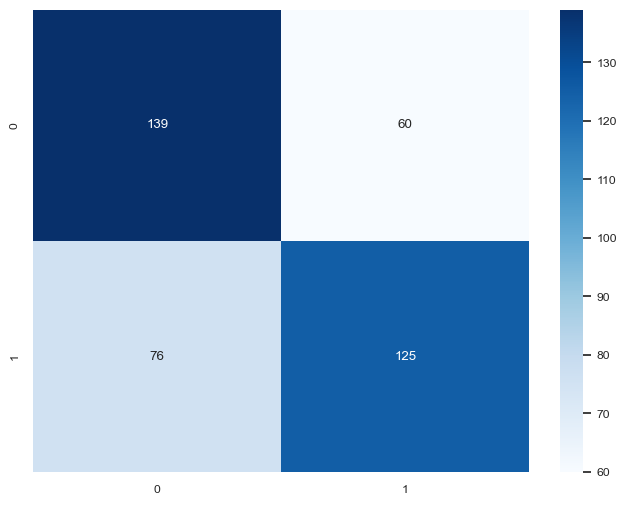

In [18]:
# Initialise model
glove_rf = RandomForestClassifier(random_state=seed)

# Train and evaluate
glove_rf_fitted = train_and_eval_classifier(model=glove_rf, X_train=glove_embeddings_train, y_train=labels_train, X_test=glove_embeddings_test, y_test=labels_test, filename="glove_rf")

### Support Vector Machine

Accuracy: 70.0%
Precision: 72.1%
Recall: 65.7%
F1 score: 68.8%
Confusion Matrix:


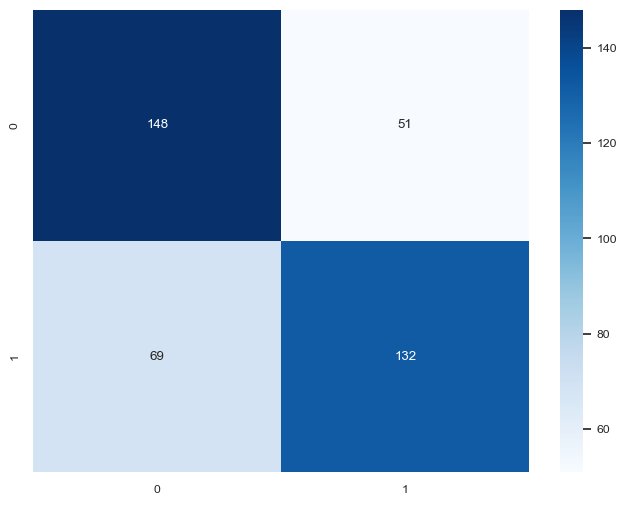

In [19]:
# Initialise model
glove_svm = SVC(random_state=seed)

# Train and evaluate
glove_svm_fitted = train_and_eval_classifier(model=glove_svm, X_train=glove_embeddings_train, y_train=labels_train, X_test=glove_embeddings_test, y_test=labels_test, filename="glove_svm")

### XGBoost

Accuracy: 65.5%
Precision: 67.2%
Recall: 61.2%
F1 score: 64.1%
Confusion Matrix:


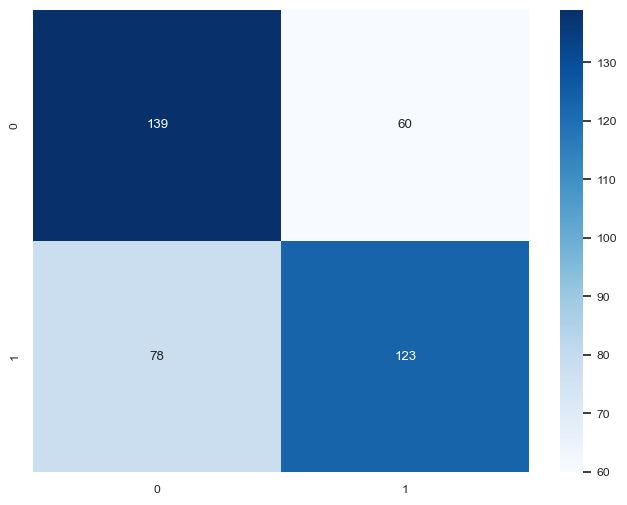

In [20]:
# Initialise model
glove_xgb = XGBClassifier(random_state=seed)

# Train and evaluate
glove_xgb_fitted = train_and_eval_classifier(model=glove_xgb, X_train=glove_embeddings_train, y_train=labels_train, X_test=glove_embeddings_test, y_test=labels_test, filename="glove_xgb")